In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

In [2]:
data1 = pd.read_parquet("/Users/sykuznetsov/Documents/GitHub/ml_zoom_camp/data/fhv_tripdata_2021-01.parquet")
data1['month'] = 1
data2 = pd.read_parquet("/Users/sykuznetsov/Documents/GitHub/ml_zoom_camp/data/fhv_tripdata_2021-02.parquet")
data2['month'] = 2
data = pd.concat([data1, data2])

In [3]:
print(data1.shape)

(1154112, 8)


In [4]:
data['duration'] = (data['dropOff_datetime'] - data['pickup_datetime'])
data['duration'] = data['duration'].dt.total_seconds() / 60
data.loc[data['month'] == 1, 'duration'].mean()

19.167224093791006

<AxesSubplot:>

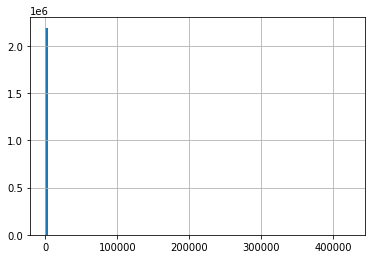

In [5]:
data['duration'].hist(bins=100)

In [6]:
correct_duration_flag = (data['duration'] >= 1) & (data['duration'] <= 60)
print((~ correct_duration_flag).sum())

data = data[correct_duration_flag]

91865


In [7]:
data['PUlocationID'] = data['PUlocationID'].fillna(-1)
data['DOlocationID'] = data['DOlocationID'].fillna(-1)
(data['PUlocationID'] == -1).mean()

0.8455812287880743

In [8]:
# X_train = all_feat[data['month'] == 1]
y_train = data.loc[data['month'] == 1, 'duration']

# X_val = all_feat[data['month'] == 2]
y_val = data.loc[data['month'] == 2, 'duration']

data_train = data[data['month'] == 1]
data_val = data[data['month'] == 2]

In [9]:
def add_dummies(train, val, columns):
    train_ohe_list = []
    val_ohe_list = []
    for column in columns:
        train_ohe = pd.get_dummies(train[column])
        val_ohe = pd.get_dummies(val[column])

        train_ohe.columns = [f"{column}_{c}" for c in train_ohe.columns]
        val_ohe.columns = [f"{column}_{c}" for c in val_ohe.columns]

        col_intersec = list(set(val_ohe.columns).intersection(set(train_ohe.columns)))
        col_diff = list(set(train_ohe.columns).difference(set(val_ohe.columns)))

        val_ohe = val_ohe[col_intersec]
        val_ohe.loc[:, col_diff] = 0
        val_ohe = val_ohe[train_ohe.columns]

        train_ohe_list.append(train_ohe)
        val_ohe_list.append(val_ohe)


    return pd.concat(train_ohe_list, axis=1), pd.concat(val_ohe_list, axis=1)


X_train, X_val = add_dummies(data_train, data_val, ['PUlocationID', 'DOlocationID'])


In [10]:
X_train

,PUlocationID_-1.0,PUlocationID_1.0,PUlocationID_2.0,PUlocationID_3.0,PUlocationID_4.0,PUlocationID_5.0,PUlocationID_6.0,PUlocationID_7.0,PUlocationID_8.0,PUlocationID_9.0,...,DOlocationID_256.0,DOlocationID_257.0,DOlocationID_258.0,DOlocationID_259.0,DOlocationID_260.0,DOlocationID_261.0,DOlocationID_262.0,DOlocationID_263.0,DOlocationID_264.0,DOlocationID_265.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154107,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1154108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1154109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1154110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107168236

In [12]:
y_pred_val = lr.predict(X_val)
mean_squared_error(y_val, y_pred_val, squared=False)

11.014283145112222